In [157]:
from xopto.mcml import mc
from xopto.cl import clinfo
from xopto.materials.absorption import oxyhem, deoxyhem
from xopto.materials import skin
from xopto.materials.skin import ReducedScatteringPower

import numpy as np
import matplotlib.pyplot as pp

In [158]:
cl_device = clinfo.gpu()

In [159]:
nphotons = 1e6
wavelengths = np.arange(399e-9, 801e-9, 2e-9)

/home/mikhail/Projects/Skoltech/Biophotonics/light-in-skin-animation/pyxopto/xopto/materials/absorption/base.py:137: UserWarning: Wavelength is out of valid range [100.0, 799.5] nm!
  warnings.warn(


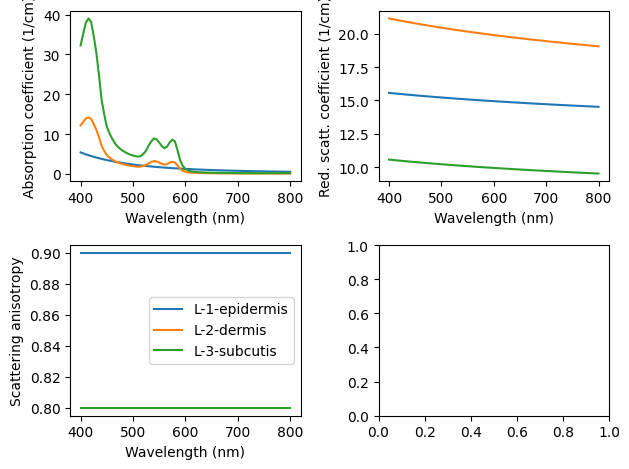

In [160]:
model_normal = skin.Skin3()

epidermis = model_normal[0]
epidermis.melanin = 0.003                    # lower melanin content

dermis = model_normal[1]
dermis.blood = 0.01                    # lower blood volume fraction

model_normal.plot()

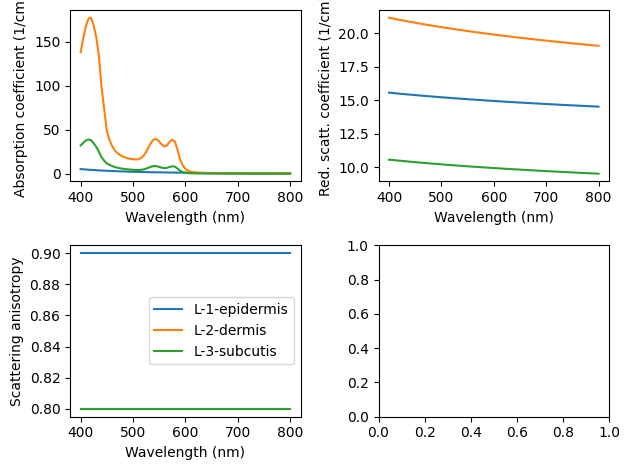

In [161]:
model_hemangioma = skin.Skin3()

epidermis = model_hemangioma[0]
epidermis.melanin = 0.003                    # lower melanin content

dermis = model_hemangioma[1]

dermis.blood = 0.15                    # augment blood volume fraction
dermis.spo2  = 0.80                    # lower oxygen saturation a bit
# dermis.musr  = ReducedScatteringPower(30e2, 0.15, 580e-9)  # optional

model_hemangioma.plot()

In [162]:
display(model_normal)
display(model_hemangioma)

Skin3
SkinLayer(d=0.000100, n=water.Daimon(t=293.15), musr=ReducedScatteringPower(a=1500.000000, b=0.100000, wavelength=5.8e-07), g=ConstantValue(0.9) # 132794460828096, baseline_absorption=EpidermisBaselineAbsorption(gamma=0.500000), melanin=0.003000, carotenoid=0.000000, water=0.020000, fat=0.000000, blood=0.000000, spo2=0.970000
SkinLayer(d=0.002000, n=skin.Ding(t=295.0), musr=ReducedScatteringPower(a=2000.000000, b=0.150000, wavelength=5.8e-07), g=ConstantValue(0.8) # 132794460859664, baseline_absorption=DermisBaselineAbsorption(kwater=1.000000, gamma=0.500000), melanin=0.000000, carotenoid=0.000000, water=0.650000, fat=0.000000, blood=0.010000, spo2=0.970000
SkinLayer(d=inf, n=skin.Ding(t=295.0), musr=ReducedScatteringPower(a=1000.000000, b=0.150000, wavelength=5.8e-07), g=ConstantValue(0.8) # 132794460720432, baseline_absorption=DermisBaselineAbsorption(kwater=1.000000, gamma=0.500000), melanin=0.000000, carotenoid=0.000000, water=0.050000, fat=0.400000, blood=0.030000, spo2=0.97

Skin3
SkinLayer(d=0.000100, n=water.Daimon(t=293.15), musr=ReducedScatteringPower(a=1500.000000, b=0.100000, wavelength=5.8e-07), g=ConstantValue(0.9) # 132794456471104, baseline_absorption=EpidermisBaselineAbsorption(gamma=0.500000), melanin=0.003000, carotenoid=0.000000, water=0.020000, fat=0.000000, blood=0.000000, spo2=0.970000
SkinLayer(d=0.002000, n=skin.Ding(t=295.0), musr=ReducedScatteringPower(a=2000.000000, b=0.150000, wavelength=5.8e-07), g=ConstantValue(0.8) # 132794456968448, baseline_absorption=DermisBaselineAbsorption(kwater=1.000000, gamma=0.500000), melanin=0.000000, carotenoid=0.000000, water=0.650000, fat=0.000000, blood=0.150000, spo2=0.800000
SkinLayer(d=inf, n=skin.Ding(t=295.0), musr=ReducedScatteringPower(a=1000.000000, b=0.150000, wavelength=5.8e-07), g=ConstantValue(0.8) # 132794567440368, baseline_absorption=DermisBaselineAbsorption(kwater=1.000000, gamma=0.500000), melanin=0.000000, carotenoid=0.000000, water=0.050000, fat=0.400000, blood=0.030000, spo2=0.97

In [163]:
# DEFINE SOURCE
source = mc.mcsource.Line(
    position=(0.0, 0.0, 0.0),
    direction=(0.0, 0.0, 1.0)
)

# DEFINE A DETECTOR FOR INTEGRATING SPHERE
sp_r = 0.5e-2  # integrating sphere opening in m
detector_top = mc.mcdetector.Radial(
    mc.mcdetector.RadialAxis(
        start=0.0,
        stop=2*sp_r,
        n=2)
)
detectors = mc.mcdetector.Detectors(
    top=detector_top
)

In [164]:
reflectance_spectrum = {
    'normal': np.zeros(len(wavelengths)),
    'hemangioma': np.zeros(len(wavelengths))
}
for i, w in enumerate(wavelengths):
    layers_normal = model_normal.create_mc_layers(w)
    layers_hemangioma = model_hemangioma.create_mc_layers(w)

    # creating a Monte Carlo simulator instance
    mc_obj_normal = mc.Mc(layers_normal, source, detectors, cl_devices=cl_device)
    mc_obj_normal.rmax = 50.0e-3

    mc_obj_hemangioma = mc.Mc(layers_hemangioma, source, detectors, cl_devices=cl_device)
    mc_obj_hemangioma.rmax = 50.0e-3

    # 
    detector = mc_obj_normal.run(nphotons, verbose=False)[-1]
    reflectance_spectrum['normal'][i] = detector.top.reflectance[0] * np.pi * sp_r**2

    detector = mc_obj_hemangioma.run(nphotons, verbose=False)[-1]
    reflectance_spectrum['hemangioma'][i] = detector.top.reflectance[0] * np.pi * sp_r**2

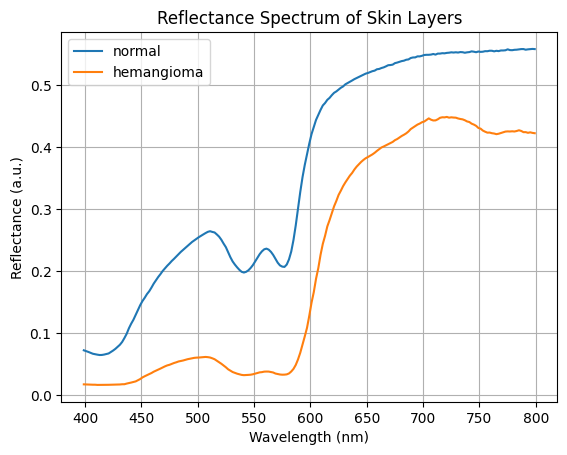

In [165]:
for key, spectrum in reflectance_spectrum.items():
    pp.plot(wavelengths * 1e9, spectrum, label=key)
pp.xlabel('Wavelength (nm)')
pp.ylabel('Reflectance (a.u.)')
pp.title('Reflectance Spectrum of Skin Layers')
pp.legend()
pp.grid()
pp.show()

In [166]:
from xopto.util import color

def plot_skin_color(reflectance_spectrum, wavelengths):
    # RGB color space and observer selection
    RGB = color.cie.SRGB
    #observer = color.cie.CIE1931 # 2 deg field of view
    observer = color.cie.CIE1964 # 10 deg field of view
    observer_cosmin = np.cos(observer.fov/2)

    k = RGB.autoexposure(wavelengths, reflectance_spectrum, observer, 1.0)
    k = 0.006999074230406075
    # compute color, correct illuminant luminosity for Lambertian reflector and
    # solid acceptance angle of the CIE observer
    rgb = RGB.from_spectrum(wavelengths, reflectance_spectrum,
                            observer=observer,
                            normalize=k)
    rgb_uint8 = np.round(np.clip(rgb, 0.0, 1.0)*255).astype(np.uint8)
    print('Raw normalized RGB components:', rgb)

    fig, ax = pp.subplots(1, 2)
    pp.suptitle('Skin color - {} color space'.format(RGB.name))
    ax[0].plot(wavelengths*1e9, reflectance_spectrum, label='Skin') #(1.0 - observer_cosmin)
    ax[0].plot(wavelengths*1e9,
                RGB.illuminant.spd(wavelengths)*k,
                label='Normalized-{}'.format(RGB.illuminant.name))
    ax[0].set_xlabel('Wavelength (nm)')
    ax[0].set_ylabel('Reflectance (a.u.)')
    ax[0].set_title('Illuminant {:s} & observer {:s}'.format(
        RGB.illuminant.name, observer.name))
    ax[0].legend()

    ax[1].imshow(np.reshape(rgb_uint8, [1, 1, 3]))
    ax[1].set_title('Skin color: RGB=({:d}, {:d}, {:d})'.format(*rgb_uint8))
    ax[1].set_axis_off()
    pp.tight_layout()
    pp.show()

Raw normalized RGB components: [0.88035933 0.59664009 0.44478429]


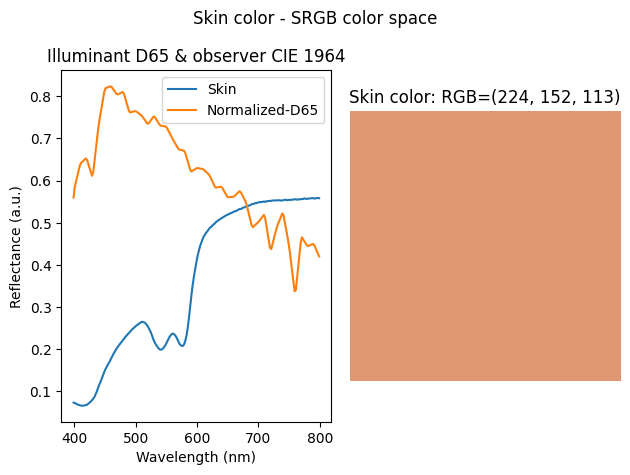

In [167]:
plot_skin_color(reflectance_spectrum['normal'], wavelengths)

Raw normalized RGB components: [0.66381594 0.24472888 0.19830159]


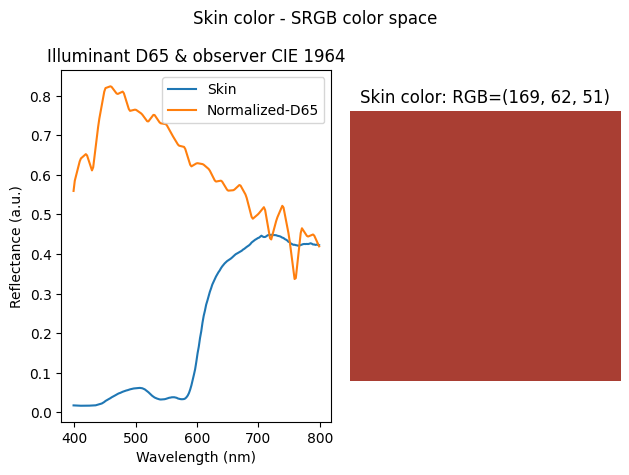

In [168]:
plot_skin_color(reflectance_spectrum['hemangioma'], wavelengths)

In [169]:
import pandas as pd

In [170]:
df_normal_true = pd.read_csv('Normal skin reflectance.csv')
df_hemangioma_true = pd.read_csv('Hemangioma skin reflectance.csv')

In [171]:
df_normal_true.head()

,Wavelength,Reflectance
0,399.941827,0.277706
1,404.304828,0.227201
2,410.122164,0.187518
3,424.665503,0.164069
4,435.573008,0.171284


In [172]:
df_normal_true.columns

Index(['Wavelength', 'Reflectance'], dtype='object')

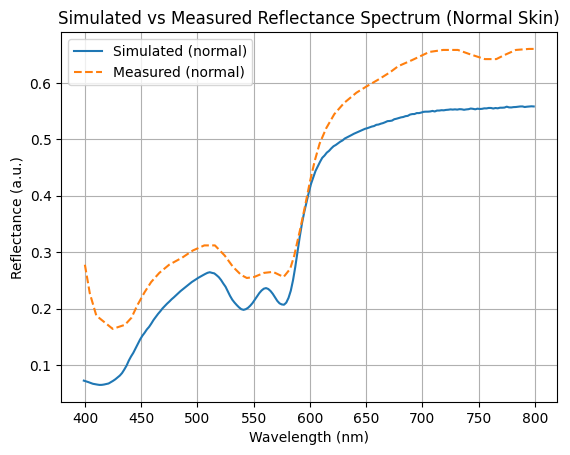

In [173]:
# Plot simulated reflectance
pp.plot(wavelengths * 1e9, reflectance_spectrum['normal'], label='Simulated (normal)')

# Plot measured reflectance
pp.plot(df_normal_true['Wavelength'], df_normal_true['Reflectance'], label='Measured (normal)', linestyle='--')

pp.xlabel('Wavelength (nm)')
pp.ylabel('Reflectance (a.u.)')
pp.title('Simulated vs Measured Reflectance Spectrum (Normal Skin)')
pp.legend()
pp.grid()
pp.show()

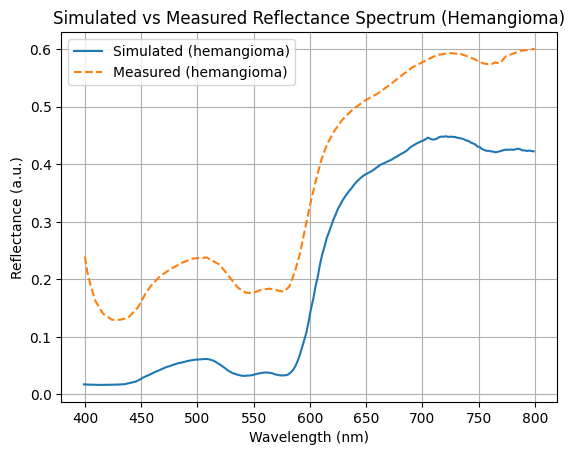

In [174]:
# Plot simulated reflectance
pp.plot(wavelengths * 1e9, reflectance_spectrum['hemangioma'], label='Simulated (hemangioma)')

# Plot measured reflectance
pp.plot(df_hemangioma_true['Wavelength'], df_hemangioma_true['Reflectance'], label='Measured (hemangioma)', linestyle='--')

pp.xlabel('Wavelength (nm)')
pp.ylabel('Reflectance (a.u.)')
pp.title('Simulated vs Measured Reflectance Spectrum (Hemangioma)')
pp.legend()
pp.grid()
pp.show()